# Imports

In [11]:
# when running into problems with modules not being found
#add the path to the repo to the python path 
# via the following two lines
import sys
sys.path.append('/home/npopkov/syndatagenerators') # <---path to the repo

import random
import numpy as np
import torch
import time
from torch.utils.data import DataLoader
from syndatagenerators.models.ddpm.utils.DiffusionUtilities import DiffusionUtilities
from syndatagenerators.models.ddpm.architectures.UNetPredictor2 import UNet_conditional
from syndatagenerators.models.ddpm.utils.Trainer import Trainer
from syndatagenerators.models.ddpm.utils.Generator import Generator
from syndatagenerators.models.ddpm.utils.dataprep_utils import create_OM_datastore,read_multiple_households_df,OMCondDataset, getWeekPeriodicEmbedding,getYearPeriodicEmbedding
from syndatagenerators.models.ddpm.utils.utils import createDirs, saveConditionsTxt
from syndatagenerators.models.ddpm.utils.experiments import evalModel_cond_multivar

# hyperparams and util initializations

In [12]:
# initialize seed-----------------------------------------------
SEED = 17
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# --------------------------------------------------------------

# hyperparam init-----------------------------------------------
batch_size = 32
n_epochs = 20
lr = 3e-4
n_steps, betaMin, betaMax = 200, 10**-6, 0.02
seq_len= 96
# --------------------------------------------------------------

# setting values for better saving -----------------------------------------------------
TIME = time.strftime('%Y-%m-%d-%H%M', time.localtime())
NAME = f'{n_steps}-{batch_size}-{betaMin}-{betaMax}-{n_epochs}'
TAG = f'{TIME}-{NAME}'
print(f'TAG: {TAG}')
# ---------------------------------------------------------------------------------------

# setting device -----------------------------------------------------------------------
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# ---------------------------------------------------------------------------------------

# create directorys --------------------------------------------------------------------
key = "live_demo"
current_path = f'/home/npopkov/syndatagenerators/syndatagenerators/models/ddpm/experiments/'
store_path = f'{current_path}{key}/{TAG}/'
createDirs(key,TAG,current_path)
print(f'Store path: {store_path}')
# ---------------------------------------------------------------------------------------

TAG: 2024-06-28-1607-200-32-1e-06-0.02-20
Using device: cpu
[Errno 17] File exists: '/home/npopkov/syndatagenerators/syndatagenerators/models/ddpm/experiments/live_demo'
[Errno 17] File exists: '/home/npopkov/syndatagenerators/syndatagenerators/models/ddpm/experiments/live_demo'
[Errno 17] File exists: '/home/npopkov/syndatagenerators/syndatagenerators/models/ddpm/experiments/live_demo/2024-06-28-1607-200-32-1e-06-0.02-20'
Store path: /home/npopkov/syndatagenerators/syndatagenerators/models/ddpm/experiments/live_demo/2024-06-28-1607-200-32-1e-06-0.02-20/


# Loading the dataset from an HDF file
We read in the hdf file and then create a dataframe which can be used to create the final training/test datasets and ultimatly dataloaders.

In [13]:
hdf = create_OM_datastore(hdf_file='/20240119_OM_privat-19-02.h5')
keys = hdf.keys()[:10]
print(f'HDF file contains following information:{hdf[keys[0]].keys().values}')
number_ids = len(keys)
df = read_multiple_households_df(keys,hdf)
hdf.close()

HDF file contains following information:['w' 't2m' 'sensor_id' 'cluster_id']


  0%|          | 0/9 [00:00<?, ?it/s]

# Choose what categorical and continual features should be used from your dataset.
F.e. our dataset has the columns `"sensor_id"` for categorical and `"week","year"` as continual conditions. At the end this information is saved to a txt file.
"week" and "year" are datetime information encoded as sin/cos values when applied for a week or a year.

In [14]:
cats = ["sensor_id"]
conts = ["week","year"]

saveConditionsTxt(store_path,cats,conts)

In [15]:
#custom dataset class for the OpenMeter dataset
#for your own dataset you need to create a similar class and adjust the implementation
dataset = OMCondDataset(df=df,
                        seq_len=seq_len,
                        cat_conditions=cats,
                        cont_conditions=conts,)

# split data for train and test (80/20)
train_ds , test_ds = torch.utils.data.random_split(dataset,[0.8,0.2])

#tweek the size of the test batch here
test_batch_size = int(len(test_ds)/500)*50

train_loader = DataLoader(dataset=train_ds,
                        batch_size=batch_size, 
                        shuffle=True,
                        drop_last=True)

test_loader = DataLoader(dataset=test_ds, 
                         batch_size=test_batch_size, 
                         shuffle=False,
                         drop_last=True)

# pulling a sample from the test dataset for later use
# it consists of categorical and continuous conditions and the corresponding time series
sample_cat, sample_cont, sample = next(iter(test_loader))

# Now we initialize the models and util classes

In [16]:
# the neural network part of the ddpm that predicts the noise
network = UNet_conditional(n_steps= n_steps,
                           c_in=1,
                           c_out=1,
                           num_classes= [18],
                           num_cont = dataset.num_cont,
                           device=device)

# the ddpm class that combines the network and many mathematical operations needed to perform denoising
ddpm = DiffusionUtilities(network=network.to(device),
                          size=seq_len,
                          betaMin=betaMin,
                          betaMax=betaMax,
                          n_steps=n_steps,
                          device=device)

# trainer util class that trains the ddpm
trainer = Trainer(ddpm=ddpm,
                  loader=train_loader,
                  batch_size=batch_size,
                  train_size=seq_len,
                  n_epochs=n_epochs,
                  lr=lr,
                  store_path=store_path,
                  device=device,
                  tag=TAG,
                  household=key)

# generator util class that generates samples from the ddpm, especially useful for evaluation
generator = Generator(model=ddpm,
                      train_dataset=train_ds,
                      n_steps=n_steps,
                      device=device,
                      tag=TAG)

/home/npopkov/.local/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


# Start training using the Trainer class

In [17]:
#trainer.train_ddpm()

# Evaluate the model
This method generates a batch of synthetic data and compares the results using different metrics proposed in this project

In [18]:
# evalModel_cond_multivar(sample=sample,
#                         test_batch_size=test_batch_size,
#                         network=network,
#                         generator=generator,
#                         device=device,
#                         train_size=seq_len,
#                         gen_size=seq_len,
#                         store_path=store_path,
#                         cats=sample_cat,
#                         conts=sample_cont,)

In [19]:
store_path = '/home/npopkov/syndatagenerators/syndatagenerators/models/ddpm/experiments/web_expert_tests/2024-06-26-2138-200-32-1e-06-0.02-25/'

In [20]:
from syndatagenerators.models.ddpm.utils.utils import loadModel
loadModel(model=generator.ddpm.network, path=f'{store_path}network.pt')

You find now various results and metrics, aswell as the generated samples from above under your store_path

# Create a single sample using categorical and continual conditions
In the following we will use encoded household ID's to create our desired sample

In [97]:
desired_key = 2
print(f"This is our list of household IDs: {keys}")
print(f"Those keys where lable encoded so we have {dataset.lens_cat_conditions} households in total to choose from")
print(f"If we want to choose the {desired_key}. key in the list {keys[desired_key-1]} we would have to use the label {desired_key-1}")

This is our list of household IDs: ['/001dce72-b1c1-44b1-bf16-0c22cfe3a420', '/00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d', '/0252a8f5-9913-47bb-a70f-c86e5c69f71a', '/026ed97d-d51e-489a-898e-6547d6f569f2', '/02a7475b-9007-4aef-a265-b38bbdbbec32', '/0358067f-cd41-4d91-ba9e-91405fbfc704', '/037d3c0e-2c33-4705-a6a4-778ce0858c85', '/04b1dc78-587d-4837-978e-ac288a2b480c', '/0670c6d3-ba11-476c-aac5-c63e399e27c3', '/06d1421b-265b-4a13-a39f-6df00dbf92a6']
Those keys where lable encoded so we have [10] households in total to choose from
If we want to choose the 2. key in the list /00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d we would have to use the label 1


In [98]:
household_id = desired_key - 1 #because you should always start counting at 0 
categorical_cond = torch.tensor([household_id]).unsqueeze(0)
print(categorical_cond.shape)

torch.Size([1, 1])


Continual conditions are created using datetime informationen which is then converted into an sin/cos representation that can be understood by our model

In [99]:
import pandas as pd
#created a one day date range with 15 minute intervals
desired_date = pd.date_range(start=f"{2021}-01-01 00:00:00", end=f"{2021}-01-01 23:45:00", freq='0.25H')

#embed the date into the periodic sin/cos space
week = getWeekPeriodicEmbedding(desired_date)
year = getYearPeriodicEmbedding(desired_date)

continual_cond = torch.cat([torch.from_numpy(week),torch.from_numpy(year)],dim=1).float()[0,:].unsqueeze(0)
print(continual_cond.shape)

torch.Size([1, 4])


Now we can generate one sample with the length of one day

In [122]:
synthetic_data = generator.generate_one_cond_sample(cat=categorical_cond, 
                                                    cont=continual_cond,
                                                    seq_len=seq_len)

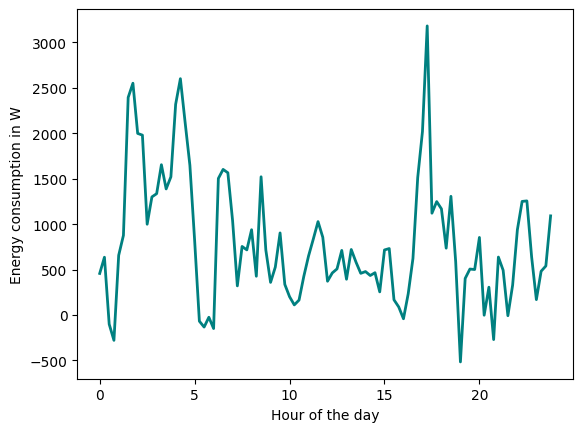

In [123]:
import matplotlib.pyplot as plt 
retransformed_data = synthetic_data * dataset.max

plt.plot(np.arange(0,24,0.25),retransformed_data.squeeze().cpu().detach().numpy(),linewidth=2,c='teal')
plt.xlabel('Hour of the day')
plt.ylabel('Energy consumption in W')
plt.show()